# Recurrent Neural Networks

## Core Ideas

1. Allow us to operate over sequences of vectors (in the input and the output) as opposed to normal feed-forward neural networks and convolutional neural networks which require fixed length vectors.
2. Are effective in representing conditional memory - next output is determined from the one before (temporal dependencies).

## Applications

![title](img/sequences.png)

One to many - Image captioning <br>
Many to one - Sentiment classification <br>
Many to many - Translation (sequence of words -> sequence of words) <br>
Many to many (one to one correspondence between input and output) - Video classification on frame level <br>

# How RNNs Work

### Recurrent Neuron
![title](img/recurrentneuron.png) <br>

### Recurrence Relation
Each "cell" has an internal state that gets updated with each input:
$$ h_t = \phi(W_R * h_{t-1} + W_I * x_t + b_h)$$ 
$$ \hat{y_t} = g_y(W_{y} * h_t + b_y) $$
$ h_t $ = new state <br>
$ \phi $ = Some activation function <br>
$ W_{R} $ = Matrix of weights connecting hidden layer to hidden layer <br>
$ h_{t-1} $ = Previous hidden state <br>
$ W_{I} $ = Matrix of weights connecting input layer to hidden layer <br>
$ x_t $ = Input vector at time step t <br>
$ b_h $ = Bias vector for hidden layer <br>
$ \hat{y_t} $ = Predicted vector for time step t <br>
$ y_t $ = Actual vector for time step t <br>
$ g_y $ = Function to get normalized probabilities, softmax $(\frac {e^{f_k}}{
\sum_{j} e^{f_j}})$<br>
$ W_{Y} $ = Matrix of weights connecting hidden layer to output layer <br>
$ b_y $ = Bias vector for output layer <br>


### Computation Graph Unrolled
![title](img/unrolled.png) <br>
-  Reuse same weight matrix $W_R$, can be thought of as a transition matrix in a Markov Chain
-  Network emits output at every timestep

### Backpropagation Through Time
![title](img/cost_unrolled.png) <br>
We define our cost function to be cross entropy:
$$ C(y, \hat{y}) = - \sum_{t} y_t \log{\hat{y}_t}$$
Backpropagation Through Time is the application of backpropagation  but after the network has been unrolled for all input timesteps. The key difference is that we sum up the gradients for the parameter at each time step. In a traditional neural network we don’t share parameters across layers, so we don’t need to sum anything. <br>

We proceed by calculating the gradients of the cost with respect to our parameters $W_I$, $W_R$ and $W_y$ <br>
Using the cost at time step 2 as an example: <br>
Calculating the gradient for $W_y$ only depends on the values at the current time step <br>
$$\frac{\partial C_2}{\partial W_y} =  \frac{\partial C_2}{\partial \hat{y}_2} * \frac{\partial \hat{y}_2}{\partial h_2} * \frac{\partial h_2}{\partial W_y} $$ <br>
We do the same thing with $W_R$:
$$ \frac{\partial C_2}{\partial W_R} = \frac{\partial C_2}{\partial \hat{y}_2} * \frac{\partial \hat{y}_2}{\partial h_2} * \frac{\partial h_2}{\partial W_R} $$ <br>
However, $h_2 = \phi(W_R * h_1 + W_I * x_t + b_h)$ which depends on $h_1$ and thus $W_R$. Therefore, we cannot treat $h_2$ as a constant. $W_R$ is used in every step of the output, so we need to backpropagate gradients from t=2 all the way to t=0.
$$ \frac{\partial C_2}{\partial W_R} = \sum_{t=0}^2 \frac{\partial C_2}{\partial \hat{y}_2} * \frac{\partial \hat{y}_2}{\partial h_2} * \frac{\partial h_2}{\partial h_t} * \frac{\partial h_t}{\partial W_R} $$<br>
The same reasoning applies for $W_I$

# Vanishing/Exploding Gradient Problem
This idea of propagating all the way to time = 0 introduces the issue of vanishing or exploding gradients. The magnitude of the update for the weight matrix is going to scale with the size of weight matrices:
$$ \frac{\partial C_T}{\partial W_R} \propto |W_R|^T * |\frac{\partial \hat{y}}{\partial h}|^T $$
<br>
If the recurrent weight is less than 1, then if you want to calculate the gradient at t=100, it will ne nearly 0. Alternatively, if $W_R$ is greater than 1, you will run into the problem of exploding gradients. There are ways to combat this issue: <br>
<b> Exploding Gradient </b> <br>
Truncuated Backpropagation Through Time - Instead of going from t= 100 to t =0, you will stop after for example 10 time steps, but then you lose temporal context. <br>
Clip Gradients at Threshold - If a gradient is larger than a certain number, you just clip it to that number. <br>
RMSprop to adjust learning rate - adaptive learning rate algorithm that adjusts learnign rate. <br>
<b> Vanishing Gradients </b> <br>
Harder to detect <br>
Weight initialization <br>
ReLu activation <br>
RMSprop <br>
Other Architectures - LSTMs and GRUs <br>



# Minimal character-level Vanilla RNN model

In [32]:
import numpy as np
# data I/O
#data = open('input.txt', 'r').read() # should be simple plain text file
data = "Oh, that this too, too sullied flesh would melt, Thaw, and resolve itself into a dew, Or that the Everlasting had not fixed His canon"
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print ('data has %d characters, %d unique.' % (data_size, vocab_size))
#Creating dictionaries for one hot encodings
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 133 characters, 25 unique.


In [48]:
#Example one hot encoding of letter a
a_array = np.zeros((vocab_size, 1))
a_array[char_to_ix['a']] = 1
a_array.ravel()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.])

In [34]:
# hyperparameters
hidden_size = 100 # size of hidden layer of neurons
seq_length = 25 # number of steps to unroll the RNN for
learning_rate = 1e-1

In [41]:
# Model parameters
Wxh = np.random.randn(hidden_size, vocab_size)*0.01 # input to hidden (W_I)
Whh = np.random.randn(hidden_size, hidden_size)*0.01 # hidden to hidden (W_R)
Why = np.random.randn(vocab_size, hidden_size)*0.01 # hidden to output (W_y)
bh = np.zeros((hidden_size, 1)) # hidden bias 
by = np.zeros((vocab_size, 1)) # output bias 

In [42]:
def lossFun(inputs, targets, hprev):
    """
    Takes in inputs and target lists at current time step and hidden state at the previous time step.
    Returns the loss, gradients on model parameters, and last hidden state.
    """
    #store our inputs, hidden states, outputs, and probability values
    xs, hs, ys, ps = {}, {}, {}, {}
    # Each of these are going to be SEQ_LENGTH(Here 25) long dicts - 1 vector per time step
    # xs will store 1 hot encoded input characters for each of 25 time steps
    # hs will store hidden state outputs for 25 time steps (100, 25 times)) plus a -1 indexed initial state
    # to calculate the hidden state at t = 0
    # ys will store targets i.e. expected outputs for 25 times (26, 25 times), unnormalized probabs
    # ps will take the ys and convert them to normalized probabilities for chars
    hs[-1] = np.copy(hprev)
    loss = 0
    # forward pass
    for t in range(len(inputs)):
        xs[t] = np.zeros((vocab_size,1)) # encode in 1-of-k representation
        xs[t][inputs[t]] = 1 #same thing as for 'a' above
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh) # hidden state
        ys[t] = np.dot(Why, hs[t]) + by # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss)
    # backward pass: compute gradients going backwards
    #initalize vectors for gradient values for each set of weights
    dWxh, dWhh, dWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
    dbh, dby = np.zeros_like(bh), np.zeros_like(by)
    dhnext = np.zeros_like(hs[0])
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t])
        dy[targets[t]] -= 1 # backprop into y.
        dWhy += np.dot(dy, hs[t].T)
        dby += dy
        dh = np.dot(Why.T, dy) + dhnext # backprop into h
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(Whh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]:
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients
    return loss, dWxh, dWhh, dWhy, dbh, dby, hs[len(inputs)-1]


In [45]:
def sample(h, seed_ix, n):
    """ 
    sample a sequence of integers from the model 
    h is memory state, seed_ix is seed letter for first time step
    """
     #create vector
    x = np.zeros((vocab_size, 1))
    #customize it for our seed char
    x[seed_ix] = 1
    #list to store generated chars
    ixes = []
    #for as many characters as we want to generate
    for t in range(n):
    #a hidden state at a given time step is a function 
    #of the input at the same time step modified by a weight matrix 
    #added to the hidden state of the previous time step 
    #multiplied by its own hidden state to hidden state matrix.
        h = np.tanh(np.dot(Wxh, x) + np.dot(Whh, h) + bh)
    #compute output (unnormalised)
        y = np.dot(Why, h) + by
    ## probabilities for next chars
        p = np.exp(y) / np.sum(np.exp(y))
    #pick one with the highest probability 
        ix = np.random.choice(range(vocab_size), p=p.ravel())
    #create a vector
        x = np.zeros((vocab_size, 1))
    #customize it for the predicted char
        x[ix] = 1
    #add it to the list
        ixes.append(ix)
    txt = ''.join(ix_to_char[ix] for ix in ixes)
    print ('----\n %s \n----' % (txt, ))

In [46]:
n, p = 0, 0
mWxh, mWhh, mWhy = np.zeros_like(Wxh), np.zeros_like(Whh), np.zeros_like(Why)
mbh, mby = np.zeros_like(bh), np.zeros_like(by) # memory variables for Adagrad                                                                                                                
smooth_loss = -np.log(1.0/vocab_size)*seq_length # loss at iteration 0                                                                                                                        
while n<=10000:
    # prepare inputs (we're sweeping from left to right in steps seq_length long)
    if p+seq_length+1 >= len(data) or n == 0:
        hprev = np.zeros((hidden_size,1)) # reset RNN memory                                                                                                                                      
        p = 0 # go from start of data
        
    #create mappings
    inputs = [char_to_ix[ch] for ch in data[p:p+seq_length]]
    targets = [char_to_ix[ch] for ch in data[p+1:p+seq_length+1]]

    # forward seq_length characters through the net and fetch gradient                                                                                                                          
    loss, dWxh, dWhh, dWhy, dbh, dby, hprev = lossFun(inputs, targets, hprev)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001

    # sample from the model                                                                                                                                                        
    if n % 1000 == 0:
        print ('iter %d, loss: %f' % (n, smooth_loss)) # print progress
        sample(hprev, inputs[0], 200)
    
    # perform parameter update with Adagrad (adaptive learning rate)                                                                                                                                                     
    for param, dparam, mem in zip([Wxh, Whh, Why, bh, by],
                                [dWxh, dWhh, dWhy, dbh, dby],
                                [mWxh, mWhh, mWhy, mbh, mby]):
        mem += dparam * dparam
        param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update                                                                                                                   

    p += seq_length # move data pointer                                                                                                                                                         
    n += 1 # iteration counter

iter 0, loss: 80.471891
----
 oTv dTgHOwcTHhEimhOTuol,eliTnoo HHTHnuecHETeldnvmhrv idToxwiExiaeorvvndtnogmgteeusadcdwuEHcOngHEnEOntfmcHenrdtofuxnwfvlwcsxf etstOfroT ggEwd,,sotflaueumTH,HtsaxgTo,mtcxOexgHOEchTHrncTu sEEflHgutuu,ooa 
----
iter 1000, loss: 43.385551
----
 r thatitot,engthawould melt, Theeltseinoo aOdew, and resolverhastiog had ve Everlastingthad not fixed Hints anOtstims iashas th, ing had ve Everiad noo f no thie too, fixed Hirit the rlied Hing had Hi 
----
iter 2000, loss: 16.600909
----
 ullind llo, Thaelit tot, too r tos sringthaw, and resolve itself into a dew, Or that the Everlasting had not fixed Hiwo aed too sullied flesh would melt, Thaw, aooa Orold had no  fixtd wotielmelt, The 
----
iter 3000, loss: 6.317732
----
 hinxt lHing had not fixed Hiwathader, Overlasting had not fixed Hints andurelflesh would melt, Thaw, and resolve it eule Eve itself into a dew, Or that the Everlasting had not fixed Hinth Hind resolve 
----
iter 4000, loss: 2.453180
----
 ling had not

KeyboardInterrupt: 

# RNN Extensions

Over the years researchers have developed more sophisticated types of RNNs to deal with some of the shortcomings of the vanilla RNN model.

# Bidirectional RNNs
 These are based on the idea that the output at time t may not only depend on the previous elements in the sequence, but also future elements. For example, to predict a missing word in a sequence you want to look at both the left and the right context. They are just two RNNs stacked on top of each other. The output is then computed based on the hidden state of both RNNs

# LSTM
Are a special kind of RNN, capable of learning long-term dependencies and working around the vanishing gradient problem.

![title](img/LSTMRNN.png) <br>


An LSTM has three gates that control the cell state.

# LSTM Example (Keras)

In [69]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt

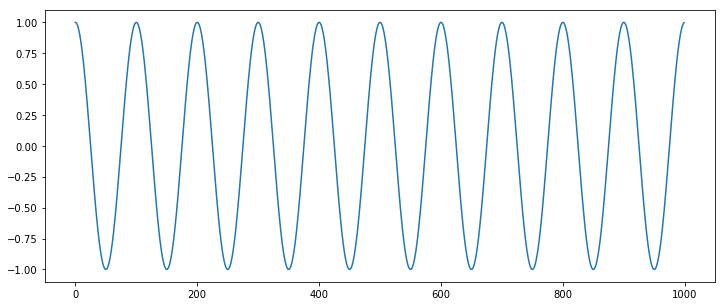

In [63]:
#Plotting Cosine Graph
plt.figure(figsize=(12,5))
dataset = np.cos(np.arange(1000)*(20*np.pi/1000))[:,None]
plt.plot(np.arange(len(dataset)), dataset)
plt.show()

In [54]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [55]:
look_back = 20
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [68]:
#Actual Keras code for model
batch_size = 16
model = Sequential()
model.add(LSTM(32,input_shape=(None, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2)

Epoch 1/1
2s - loss: 0.1609


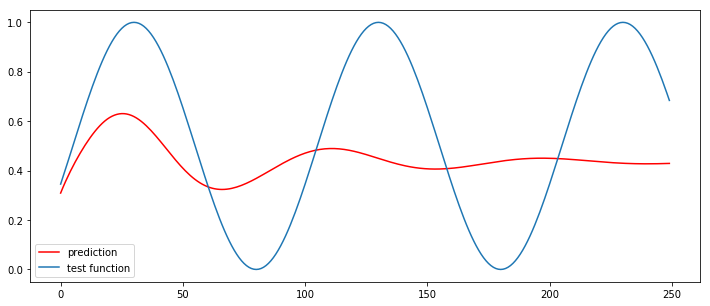

In [58]:
look_ahead = 250
trainPredict = [np.vstack([trainX[-1][1:], trainY[-1]])]
predictions = np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction = model.predict(np.array([trainPredict[-1]]), batch_size=batch_size)
    predictions[i] = prediction
    trainPredict.append(np.vstack([trainPredict[-1][1:],prediction]))
plt.figure(figsize=(12,5))
plt.plot(np.arange(look_ahead),predictions,'r',label="prediction")
plt.plot(np.arange(look_ahead),dataset[train_size:(train_size+look_ahead)],label="test function")
plt.legend()
plt.show()

# Keras LSTM Exercise